In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import fastai
import fastai.tabular
from fastai.vision.all import *
from fastai.data.core import DataLoaders

import sys 
sys.path.insert(0, '/home/gridsan/ssarangerel/mocat-ml')

from CNN import *
import random, os, h5py, json

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

path = '/home/gridsan/ssarangerel/mocat-ml/'
with open(f'{path}data_numpy/data_config.json', "r") as outfile:
    data = json.load(outfile, strict=False)
    
extent = list(data['extent'])
data_numpy = np.load(f'{path}data_numpy/data.npy')
num_sim, split, batch_size = 100, 0.90, 8192
n_epochs = 35 #number found from lr_finder nb
d = 32
save_models = True

indices = [i for i in range(num_sim)]
random.shuffle(indices)

train_data = CustomDataset(data_numpy, indices[:int(split * num_sim)], device)
val_data = CustomDataset(data_numpy, indices[int(split * num_sim):], device)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)

Selected device: cuda


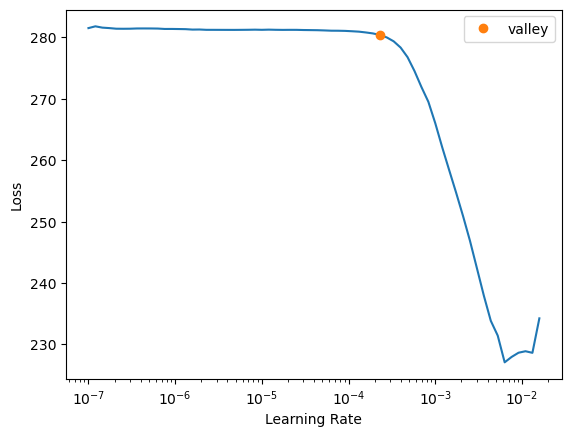

In [3]:
autoenc = AutoEncoder(d).to(device)
dls = DataLoaders.from_dsets(train_data, val_data, bs = batch_size)
learn = Learner(dls, autoenc, loss_func = F.mse_loss)
lr = learn.lr_find().valley

epoch,train_loss,valid_loss,time
0,280.997406,282.044037,00:18
1,279.879486,277.975159,00:18
2,270.365204,233.466049,00:20
3,225.428635,134.105911,00:19
4,174.849625,93.428162,00:19
5,133.408936,66.305725,00:20
6,100.259979,46.081516,00:20
7,75.154976,35.339020,00:20
8,57.564716,30.686193,00:20
9,46.093826,28.824787,00:19


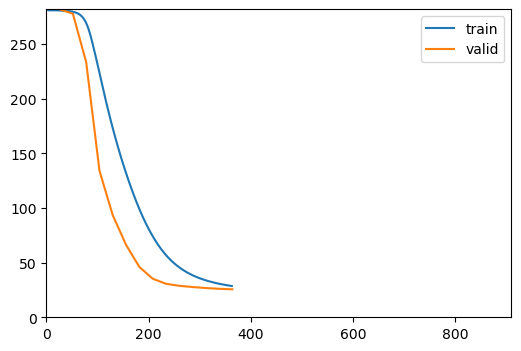

In [ ]:
#Training
learn.fit_one_cycle(n_epochs, lr, cbs=[ShowGraphCallback()])

In [ ]:
if save_models:
    model_name = f'd_{d}_epoch_{n_epochs}_split_{split}'
    torch.save(learn.model, f'{path}models/{model_name}.pt')
    file = open(f'{path}models/indices_{model_name}.txt','w')
    file.write(str(split)+" ")
    for item in indices:
        file.write(str(item)+" ")
    file.close()

In [ ]:
for img_batch, _ in dls.train:
    img = img_batch[0].to(device)
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(learn.decrypt(learn.encrypt(img)).cpu().detach().numpy()[0], extent = extent, aspect = 'auto')
    axs[1].imshow(learn.decrypt(learn.encrypt(img)).cpu().detach().numpy()[0], extent = extent, aspect = 'auto')
    plt.show()
    plt.close(fig)
    break

In [ ]:
#Validation loss
valid_loss = learn.validate()[0]
%store valid_loss